# Lab 6: Modeling (simple) compositions

**TODO 0**: Put your name and group members' name here.

Xiang Fu

In [ ]:
!pip install gensim

import csv
import os
os.environ["GENSIM_DATA_DIR"] = "/projectnb/lx496/xfu"
import numpy as np

import gensim.downloader as api
from scipy.stats import spearmanr

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

## Step 0: Preamble
In Tuesday's lecture, we looked at the approach of Mitchell & Lapata (2008) for modeling a very simple composition of an intransitive verb and its subject using functions that take word vectors as arguments.

Unfortunately, the human similarity judgment data they collected is not available publicly, so we will only do a very rough replication of the results we discussed. To give you a better sense of working with a larger dataset, we will first practice calculating word similarity (for single words) with a different dataset from SemEval 2017. You can find more details about this dataset in the accompanying paper: https://aclanthology.org/S17-2002.pdf

## Step 1: Load the SemEval 2017 Word Similarity Dataset for English

* Expression pairs: `/projectnb/lx496/shared/data/en.test.data.txt`
* Human similarity: `/projectnb/lx496/shared/data/en.test.gold.txt`

Each line in `en.test.data.txt` is a tab-separated (tab character is "\t") pair of two expressions, where the first line contains the expression pair "Joule" (the unit of energy) and "spacecraft".
Each line in `en.test.gold.txt` contains the mean similarity rating of each expression pair collected from human participants, where the first line contains the value 0.58. Here is the description of the scale taken from https://alt.qcri.org/semeval2017/task2/index.php?id=data-and-tools:

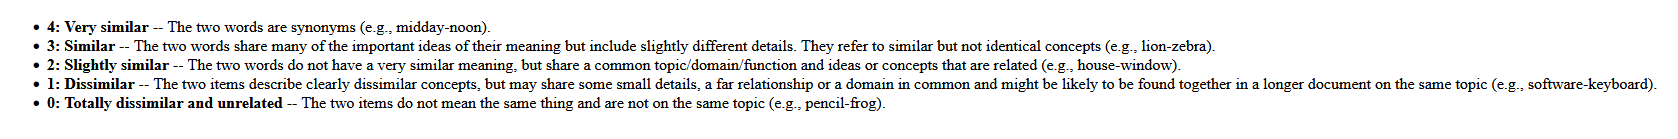

**TODO 1**: Load the expression pairs data and the human similarity data by reading the above two files. Store them in any data structure you like, but remember that each line of the two files correspond to each other. (For example, the human judged similarity between "Joule" and "spacecraft" is 0.58, which is very dissimilar according to the scale above)

Inspect the similarity scores assigned to the first few pairs. Do you agree with the judgment?

In [3]:
expression_tuples = []
human_similarities = []

# Put your code here

# Load expression pairs
with open("/projectnb/lx496/shared/data/en.test.data.txt", "r") as file:
    for line in file:
        exp1, exp2 = line.strip().split("\t")
        expression_tuples.append((exp1, exp2))

# Load human similarity scores
with open("/projectnb/lx496/shared/data/en.test.gold.txt", "r") as file:
    for line in file:
        score = float(line.strip())
        human_similarities.append(score)

print(expression_tuples[:10])
print(human_similarities[:10])

[('Joule', 'spacecraft'), ('Promised Land', 'Baku'), ('car', 'bicycle'), ('polyhedron', 'actor'), ('multiple sclerosis', 'MS'), ('fault', 'system'), ('weapon', 'helmet'), ('screenwriter', 'television'), ('United Nations', 'Ban Ki-moon'), ('Si-o-seh pol', 'Mathematical Bridge')]
[0.58, 0.42, 2.83, 0.0, 3.92, 0.58, 1.83, 1.67, 2.5, 3.0]


## Step 2: Load word vectors

We will now load word vectors, which we will take as the semantic representation of words. We will use representations from a model called GloVe (https://nlp.stanford.edu/projects/glove/), trained on Wikipedia (from 2014) and the Gigaword corpus (https://catalog.ldc.upenn.edu/LDC2003T05). This model contains vector representations of 400,000 English words.

First, make sure that the following cell prints `/projectnb/lx496/shared/data`. If not, go back to the top of this notebook and run the first cell.

In [4]:
print(api.BASE_DIR)

/projectnb/lx496/xfu


In [5]:
# Download and load the model directly from Stanford NLP, it may take a while..

# Download the GloVe vectors
url = "https://nlp.stanford.edu/data/glove.6B.zip"
os.system(f"wget {url}")

# Unzip the downloaded file
os.system("unzip glove.6B.zip")

# Convert the GloVe file to Word2Vec format
glove_input_file = "glove.6B.100d.txt"
word2vec_output_file = "glove.6B.100d.txt.word2vec"
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted model
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

--2024-03-28 21:22:33--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-28 21:22:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

     0K .......... .......... .......... .......... ..........  0%  730K 19m14s
    50K .......... .......... .......... .......... ..........  0%  730K 19m14s
   100K .......... .......... .......... .......... ..........  0%  729K 19m14s
   150K .......... .......

Archive:  glove.6B.zip


You can access the word vectors from the model by indexing it with a string, like `model["cat"]`. As you can see below, this will give you a 100 dimensional vector for "cat".

In [6]:
model["cat"]

array([ 0.23088  ,  0.28283  ,  0.6318   , -0.59411  , -0.58599  ,
        0.63255  ,  0.24402  , -0.14108  ,  0.060815 , -0.7898   ,
       -0.29102  ,  0.14287  ,  0.72274  ,  0.20428  ,  0.1407   ,
        0.98757  ,  0.52533  ,  0.097456 ,  0.8822   ,  0.51221  ,
        0.40204  ,  0.21169  , -0.013109 , -0.71616  ,  0.55387  ,
        1.1452   , -0.88044  , -0.50216  , -0.22814  ,  0.023885 ,
        0.1072   ,  0.083739 ,  0.55015  ,  0.58479  ,  0.75816  ,
        0.45706  , -0.28001  ,  0.25225  ,  0.68965  , -0.60972  ,
        0.19578  ,  0.044209 , -0.31136  , -0.68826  , -0.22721  ,
        0.46185  , -0.77162  ,  0.10208  ,  0.55636  ,  0.067417 ,
       -0.57207  ,  0.23735  ,  0.4717   ,  0.82765  , -0.29263  ,
       -1.3422   , -0.099277 ,  0.28139  ,  0.41604  ,  0.10583  ,
        0.62203  ,  0.89496  , -0.23446  ,  0.51349  ,  0.99379  ,
        1.1846   , -0.16364  ,  0.20653  ,  0.73854  ,  0.24059  ,
       -0.96473  ,  0.13481  , -0.0072484,  0.33016  , -0.1236

In [8]:
# Access the word vector for "cat"
cat_vector = model["cat"]
print(f"Dimension of the word vector for 'cat': {cat_vector.shape}") # Should be 100

Dimension of the word vector for 'cat': (100,)


This model object has various useful methods, like `most_similar()`. You can see that calling this method with "cat" returns various words that the model considers as similar.

In [9]:
model.most_similar("cat")

[('dog', 0.8798074722290039),
 ('rabbit', 0.7424427270889282),
 ('cats', 0.732300341129303),
 ('monkey', 0.7288709878921509),
 ('pet', 0.719014048576355),
 ('dogs', 0.7163872718811035),
 ('mouse', 0.6915250420570374),
 ('puppy', 0.6800068020820618),
 ('rat', 0.6641027331352234),
 ('spider', 0.6501135230064392)]

**TODO 2**: Verify that "cat" and "dog" are more similar than "cat" and "computer". The method for computing similarity is `.similarity(a, b)`. You should get about 0.88 for the first pair and 0.30 for the second pair.

Feel free to play around with this a bit---you will notice that the model only uses lowercase, so words like "Cat" will throw an error. The model does not contain representations for larger units, so strings like "two cats" will also throw an error.

In [11]:
# Your code here

# between "cat" and "dog"
cat_dog_similarity = model.similarity("cat", "dog")
print(f'Similarity between "cat" and "dog": {cat_dog_similarity:.2f}')

# between "cat" and "computer"
cat_computer_similarity = model.similarity("cat", "computer")
print(f'Similarity between "cat" and "computer": {cat_computer_similarity:.2f}')

Similarity between "cat" and "dog": 0.88
Similarity between "cat" and "computer": 0.30


## Step 3: Computing single-word similarities

Let's first start with computing similarities between two single-word pairs in our SemEval dataset we loaded above. 

**TODO 3.1**: Write code that iterates over the dataset you loaded above and computes similarities between single words. You can skip the pair in the dataset under the following two conditions:

* Any of the words in the pair is a multi-word (defined as containing a whitespace)
* The model does not contain a representation for the word (indicated by `KeyError`)

Store your output (similarity values) in a list called `single_word_model_similarities`. It will also be helpful for `TODO 3.2` to keep track of the human similarities in a separate list called `single_word_human_similarities` here. Note that these two lists have to be the same length to compute correlation in the next TODO.

Note: This model only uses lowercase, so you would need to lowercase the tuples in `expression_tuples`.

In [12]:
single_word_model_similarities = []
single_word_human_similarities = []

# Put your code here

for i, (exp1, exp2) in enumerate(expression_tuples):
    # Skip multi-word expressions
    if ' ' in exp1 or ' ' in exp2:
        continue
    
    try:
        # Compute similarity using the model
        similarity = model.similarity(exp1.lower(), exp2.lower())
        single_word_model_similarities.append(similarity)
        
        # Store the corresponding human similarity
        single_word_human_similarities.append(human_similarities[i])
    except KeyError:
        # We skip the pair if the model doesn't have a representation for a word
        continue

**TODO 3.2**: First check that your lists contain 385 items (if you didn't lowercase, you'll get fewer, like 331!). Then, verify that the Spearman correlation between model and human judged similarities is about 0.62. If you forgot how to compute correlation, look back at the MaxEnt notebook :)

In [13]:
# Put your code here

# Check the length of the lists
print(f"Number of single-word pairs: {len(single_word_model_similarities)}")

# Compute Spearman correlation
spearman_corr, _ = spearmanr(single_word_model_similarities, single_word_human_similarities)
print(f"Spearman correlation between model and human similarities: {spearman_corr:.2f}")

Number of single-word pairs: 385
Spearman correlation between model and human similarities: 0.62


**TODO 3.3**: You would have been using `model.similarity()` for TODO 3.1. The similarity function that gensim uses is cosine similarity, defined as follows:

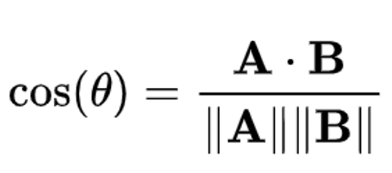

We will hopefully look into similarity metrics more in later lectures, but cosine similarity has a range between -1 and 1, and measures the _angle_ between the two vectors being compared.

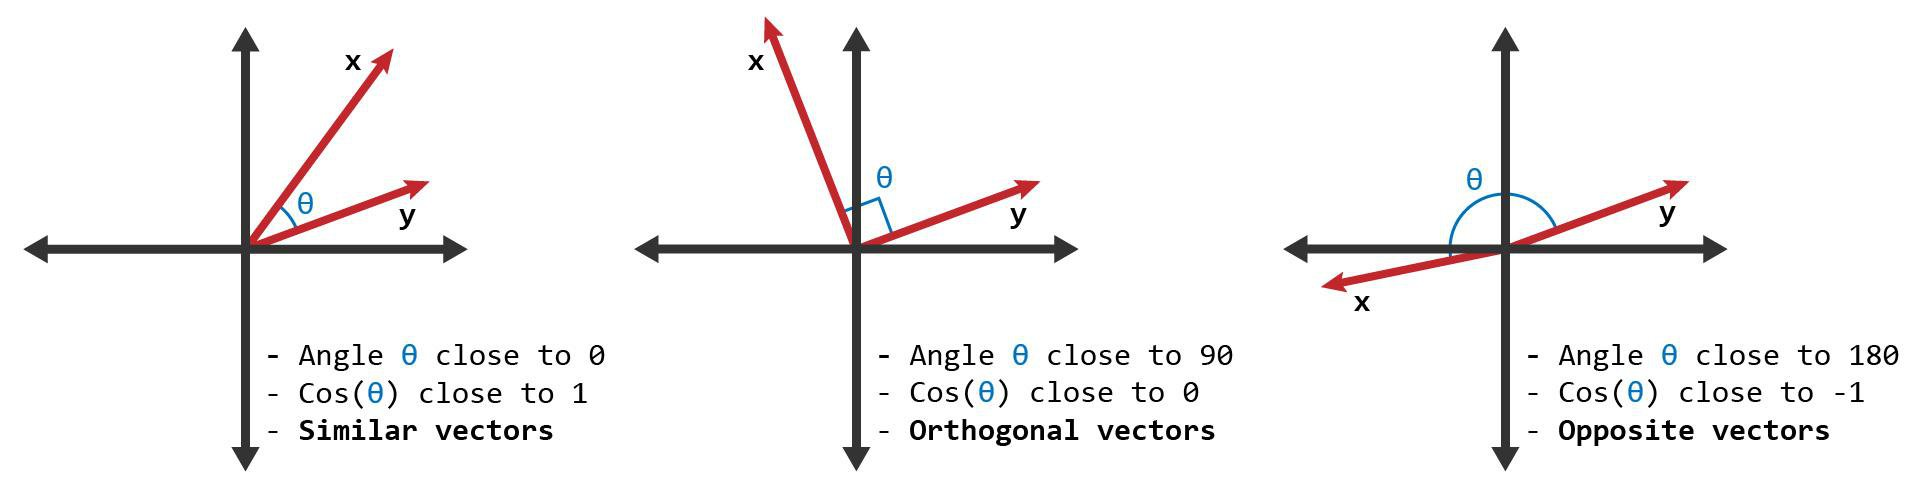
https://www.learndatasci.com/glossary/cosine-similarity/

I've written the function `cosine_sim(a, b)` for you. Rewrite the code you wrote for TODO 3.1 using this function, and verify that you get the same result from this code. Again, you can access the vectors for words direcly by doing something like `model["cat"]`.

In [14]:
def cosine_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [15]:
# Rewrite your code for TODO 3.1 using `cosine_sim` instead of model.similarity

# Verify that you get the same results as TODO 3.2 by using the code above.

single_word_model_similarities = []
single_word_human_similarities = []

for i, (exp1, exp2) in enumerate(expression_tuples):
    # Skip multi-word expressions
    if ' ' in exp1 or ' ' in exp2:
        continue
    
    try:
        # Get the word vectors for exp1 and exp2
        vec1 = model[exp1.lower()]
        vec2 = model[exp2.lower()]
        
        # Compute similarity using cosine_sim
        similarity = cosine_sim(vec1, vec2)
        single_word_model_similarities.append(similarity)
        
        # Store the corresponding human similarity
        single_word_human_similarities.append(human_similarities[i])
    except KeyError:
        # Skip the pair if the model doesn't have a representation for a word
        continue

In [16]:
# Check the length of the lists
print(f"Number of single-word pairs: {len(single_word_model_similarities)}")

# Compute Spearman correlation
spearman_corr, _ = spearmanr(single_word_model_similarities, single_word_human_similarities)
print(f"Spearman correlation between model and human similarities: {spearman_corr:.2f}")

Number of single-word pairs: 385
Spearman correlation between model and human similarities: 0.62


## Step 4: Getting multi-word vectors from composing single-word vectors

Now we're ready to start writing our composition functions! 

**TODO 4.1**: Fill in the `additive`, `multiplicative`, `unweighted_combined` functions below that take vectors $a$ and $b$ as input, based on the following definitions of the composition function:

$p=f(a, b)$

* additive: $p_i = a_i + b_i$
* multiplicative: $p_i = a_i \cdot b_i$
* unweighted_combined: $p_i = a_i + b_i + a_i \cdot b_i$

($v_i$ denotes the $i$th element in the vector $v$)

In [17]:
import numpy as np

def additive(a, b):
    return a + b

def multiplicative(a, b):
    return a * b

def unweighted_combined(a, b):
    return a + b + a * b

**TODO 4.2**: Because we do not actually have the human judgment data for the verb + subject composition from Mitchell and Lapata, we will work with a small example given in the paper (copied below). We will try to get a rough sense of the effect of the composition functions by looking at the mean model similarity for comparisons in the "High" similarity group and "Low" similarity group.

I've filled out the lists `ml_pairs_high` and `ml_pairs_low` for you. Your job here is to write code that achieves the following:

* Apply each of the three composition functions defined above to each of the expressions
* Compute similarity between the subject + verb compositions for each tuple in the list
* Show that the difference in mean across high and low similarity groups obtained using the multiplicative composition function is larger than using other functions (that is, the multiplicative function distinguishes high and low groups better)

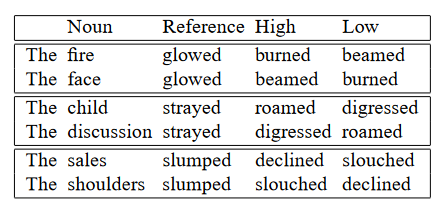

In [19]:
ml_pairs_high = [
    ("fire glowed", "fire burned"),
    ("face glowed", "face beamed"),
    ("child strayed", "child roamed"),
    ("discussion strayed", "discussion digressed"),
    ("sales slumped", "sales declined"),
    ("shoulders slumped", "shoulders slouched"),
]

ml_pairs_low = [   
    ("fire glowed", "fire beamed"),
    ("face glowed", "face burned"),
    ("child strayed", "child digressed"),
    ("discussion strayed", "discussion roamed"),
    ("sales slumped", "sales slouched"),
    ("shoulders slumped", "shoulders declined"),
]

# Write your code here

def compute_mean_similarity(pairs, composition_func):
    similarities = []
    for pair in pairs:
        exp1, exp2 = pair
        words1 = exp1.split()
        words2 = exp2.split()
        
        vec1 = composition_func(model[words1[0].lower()], model[words1[1].lower()])
        vec2 = composition_func(model[words2[0].lower()], model[words2[1].lower()])
        
        similarity = cosine_sim(vec1, vec2)
        similarities.append(similarity)
    
    return np.mean(similarities)

# Compute mean similarity for high and low groups using each composition function
composition_funcs = [additive, multiplicative, unweighted_combined]

for func in composition_funcs:
    high_mean_similarity = compute_mean_similarity(ml_pairs_high, func)
    low_mean_similarity = compute_mean_similarity(ml_pairs_low, func)
    
    print(f"Composition function: {func.__name__}")
    print(f"Mean similarity for high group: {high_mean_similarity:.2f}")
    print(f"Mean similarity for low group: {low_mean_similarity:.2f}")
    print(f"Difference in mean similarity: {high_mean_similarity - low_mean_similarity:.2f}")
    print()

Composition function: additive
Mean similarity for high group: 0.78
Mean similarity for low group: 0.77
Difference in mean similarity: 0.02

Composition function: multiplicative
Mean similarity for high group: 0.36
Mean similarity for low group: 0.26
Difference in mean similarity: 0.10

Composition function: unweighted_combined
Mean similarity for high group: 0.73
Mean similarity for low group: 0.69
Difference in mean similarity: 0.04



We can observe two thinngs from the output:

- The multiplicative composition function yields the largest difference in mean similarity between the high and low groups (0.10), compared to the additive (0.02) and unweighted_combined (0.04) functions.
- The multiplicative function distinguishes the high and low similarity groups better than the other functions, as indicated by the larger difference in mean similarity.